In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
#sys.path.append('../../../non_corrupt_starclass/starclass')
#sys.path.append('../../../shap/')

In [3]:
from matplotlib import rc
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

In [4]:
import matplotlib.pyplot as plt

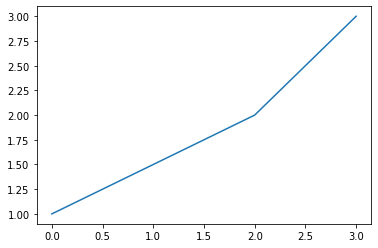

In [5]:
plt.plot([0,2,3], [1,2,3])

In [6]:
import numpy as np
import pandas as pd
import pickle
import sqlite3
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import shap
shap.initjs()

In [7]:
connection = sqlite3.connect('../starclass/training_sets/data/keplerq9/todo.sqlite')

In [8]:
df = pd.read_sql_query("select * from starclass_results;", connection)
labels = pd.read_sql_query("select * from diagnostics_corr;", connection)
labels['label'] = [i.split('/')[0] for i in labels['lightcurve'].values]
print(df.head(10))
connection.close()

   priority classifier          class          prob
0         3      slosh  RRLYR_CEPHEID  5.653244e-06
1         3      slosh      APERIODIC  9.965333e-01
2         3      slosh       CONSTANT  6.967001e-07
3         3      slosh    CONTACT_ROT  2.398802e-05
4         3      slosh      DSCT_BCEP  4.078021e-07
5         3      slosh       GDOR_SPB  2.151976e-08
6         3      slosh      SOLARLIKE  3.434777e-03
7         3      slosh        ECLIPSE  1.242193e-06
8         4      slosh  RRLYR_CEPHEID  5.226951e-08
9         4      slosh      APERIODIC  9.986894e-01


In [13]:
y = labels['label'].values[df['priority'].unique()-1].astype('U15')
y[y == 'APERIODIC'] = 'aperiodic'
y[y == 'CONSTANT'] = 'constant'
y[y == 'RRLYR_CEPHEID'] = 'RRLyr/Ceph'
y[y == 'CONTACT_ROT'] = 'contactEB/spots'
y[y == 'DSCT_BCEP'] = 'dSct/bCep'
y[y == 'ECLIPSE'] = 'transit/eclipse'
y[y == 'GDOR_SPB'] = 'gDor/spB'
y[y == 'SOLARLIKE'] = 'solar'

In [76]:
df.loc[(df['classifier'] == 'rfgc'), 'prob'].values[8:16]

array([0.00000000e+00, 9.41702936e-01, 0.00000000e+00, 2.67075338e-02,
       3.00000000e-03, 1.29206386e-04, 2.43155137e-02, 4.14481043e-03])

In [123]:
meta = df.loc[(df['classifier'] == 'meta'), 'prob'].values
meta
df.head()

,priority,classifier,class,prob
0,3,slosh,RRLYR_CEPHEID,5.653244e-06
1,3,slosh,APERIODIC,9.965333e-01
2,3,slosh,CONSTANT,6.967001e-07
3,3,slosh,CONTACT_ROT,2.398802e-05
4,3,slosh,DSCT_BCEP,4.078021e-07


In [118]:
rfgc = df.loc[(df['classifier'] == 'rfgc'), 'prob'].values.reshape(len(df)//40, 8)
slosh = df.loc[(df['classifier'] == 'slosh'), 'prob'].values.reshape(len(df)//40, 8)
xgb = df.loc[(df['classifier'] == 'xgb'), 'prob'].values.reshape(len(df)//40, 8)
rfefs = df.loc[(df['classifier'] == 'rfefs'), 'prob'].values.reshape(len(df)//40, 8)

SyntaxError: invalid syntax (<ipython-input-118-9d882a8ee347>, line 4)

In [38]:
feature_names = ['rfgc_RRLYR_CEPHEID', 'rfgc_APERIODIC', 'rfgc_CONSTANT', 
                 'rfgc_CONTACT_ROT', 'rfgc_DSCT_BCEP', 'rfgc_GDOR_SPB', 
                 'rfgc_SOLARLIKE', 'rfgc_ECLIPSE',
                 'slosh_RRLYR_CEPHEID', 'slosh_APERIODIC', 'slosh_CONSTANT', 
                 'slosh_CONTACT_ROT', 'slosh_DSCT_BCEP', 'slosh_GDOR_SPB', 
                 'slosh_SOLARLIKE', 'slosh_ECLIPSE',
                 'xgb_RRLYR_CEPHEID', 'xgb_APERIODIC', 'xgb_CONSTANT', 
                 'xgb_CONTACT_ROT', 'xgb_DSCT_BCEP', 'xgb_GDOR_SPB', 
                 'xgb_SOLARLIKE', 'xgb_ECLIPSE',
                 'rfefs_RRLYR_CEPHEID', 'rfefs_APERIODIC', 'rfefs_CONSTANT',
                 'rfefs_CONTACT_ROT', 'rfefs_DSCT_BCEP', 'rfefs_GDOR_SPB', 
                 'rfefs_SOLARLIKE', 'rfefs_ECLIPSE']
class_names = ['RRLYR_CEPHEID', 'APERIODIC', 'CONSTANT', 
                      'CONTACT_ROT', 'DSCT_BCEP', 'GDOR_SPB', 
                      'SOLARLIKE', 'ECLIPSE']

In [113]:
features = np.c_[rfgc, slosh, xgb, rfefs]
print(features.shape)

(5755, 32)


In [14]:
#with open('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle', 'rb') as pickle_file:
#with open('../starclass/data/L1/keplerq9/meta_fold01/meta_classifier.pickle', 'rb') as pickle_file:
#    model = pickle.load(pickle_file)
with open('../starclass/data/L1/keplerq9/meta_classifier.pickle', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
#model = pickle.load('../starclass/data/L1/keplerq9/meta_fold01/rfgc_classifier_v01.pickle')

In [53]:
model.feature_importances_

array([1.30857104e-02, 3.62054144e-02, 9.43440959e-03, 3.66588297e-02,
       6.81796603e-02, 1.35160384e-02, 2.86238124e-03, 3.04499663e-03,
       8.66503111e-02, 2.67527725e-02, 2.01874634e-04, 2.00255050e-02,
       5.71733723e-05, 1.92118771e-02, 1.35705371e-02, 9.83536056e-03,
       1.31169304e-02, 2.65722034e-02, 4.27467714e-02, 7.35788084e-02,
       6.79946536e-02, 7.98924618e-02, 5.85751050e-02, 2.94107644e-02,
       2.94906018e-02, 5.31579064e-02, 2.63311999e-02, 1.00690149e-02,
       6.26415478e-02, 4.71777641e-02, 1.67348084e-02, 3.21660625e-03])

In [16]:
str(type(model))

"<class 'starclass.MetaClassifier.Meta.Classifier_obj'>"

In [40]:
model.n_features_

32

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, y, 
                                                    test_size=0.1, random_state=42)

In [72]:
#model.fit(X_train, y_train)
features.shape

(5755, 32)

In [44]:
preds = model.predict(X_test)

In [67]:
accuracy_score(preds, y_test)

0.234375

In [46]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


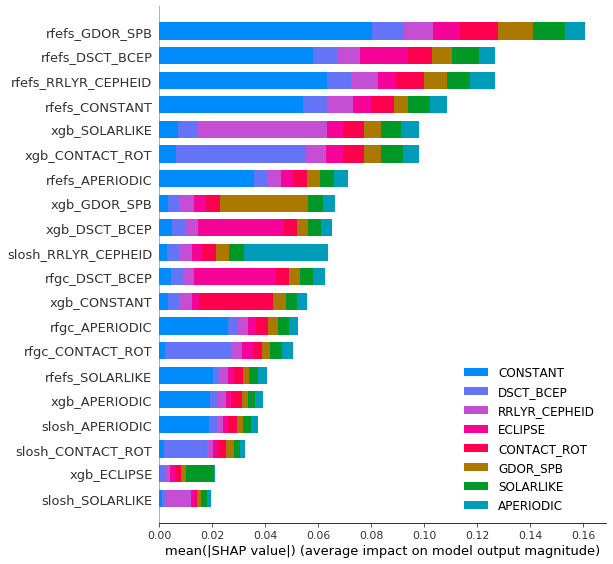

In [47]:
fig = shap.summary_plot(shap_values, X_test, 
                  feature_names=feature_names,
                  class_names=class_names)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


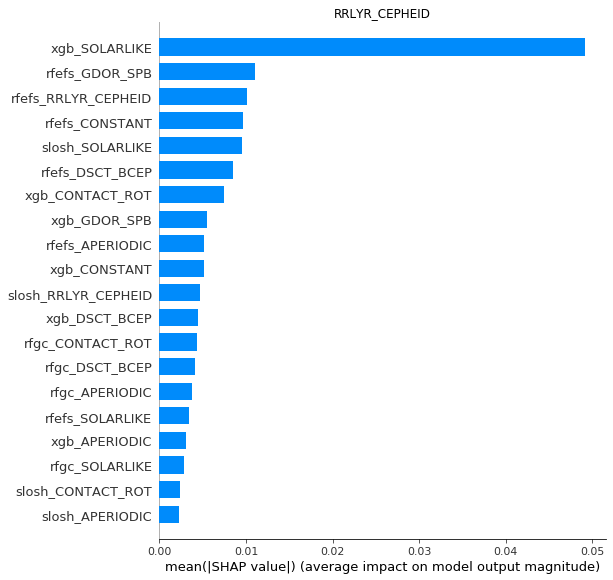

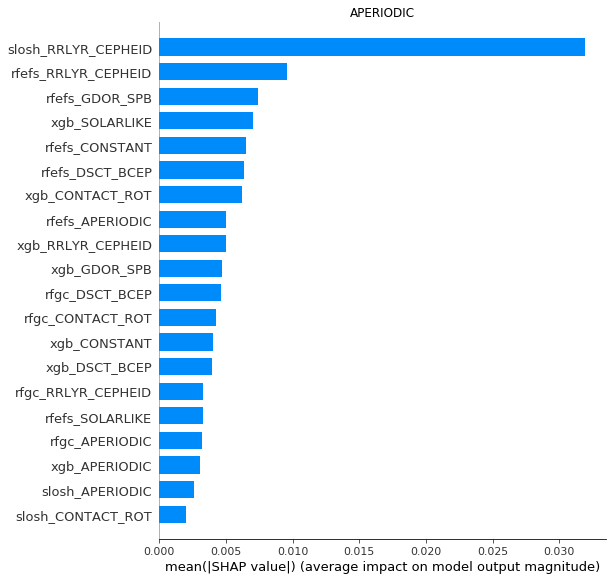

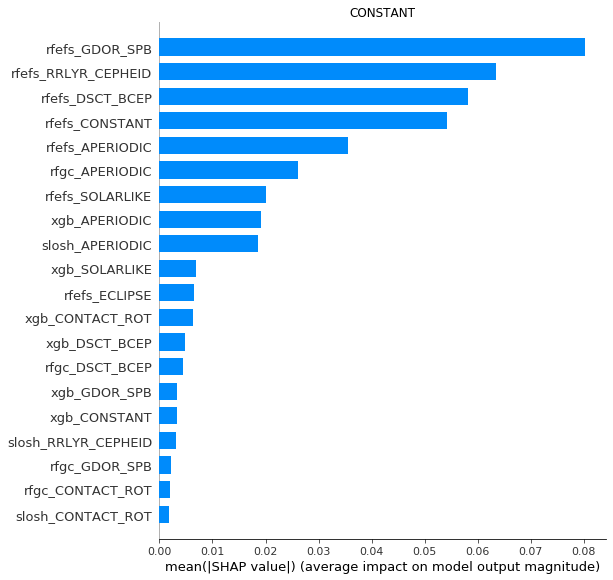

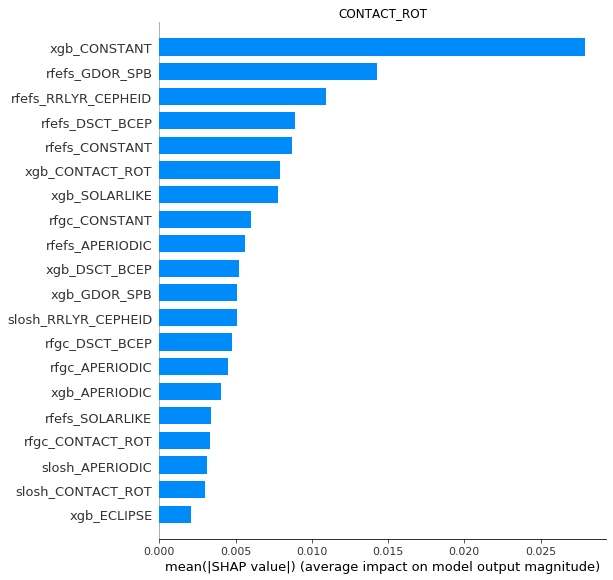

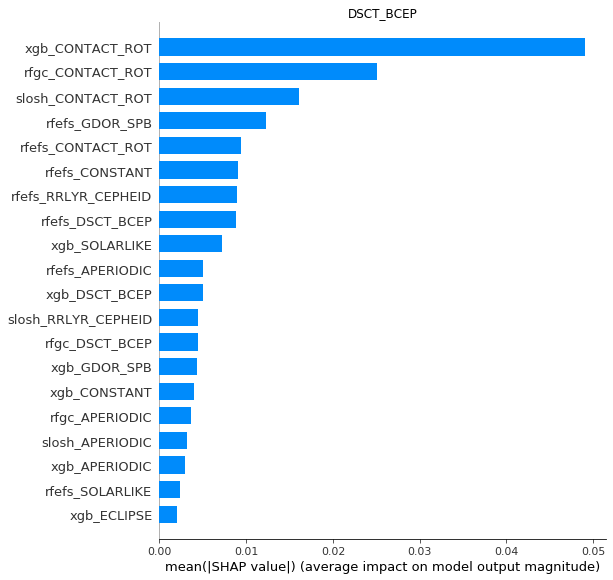

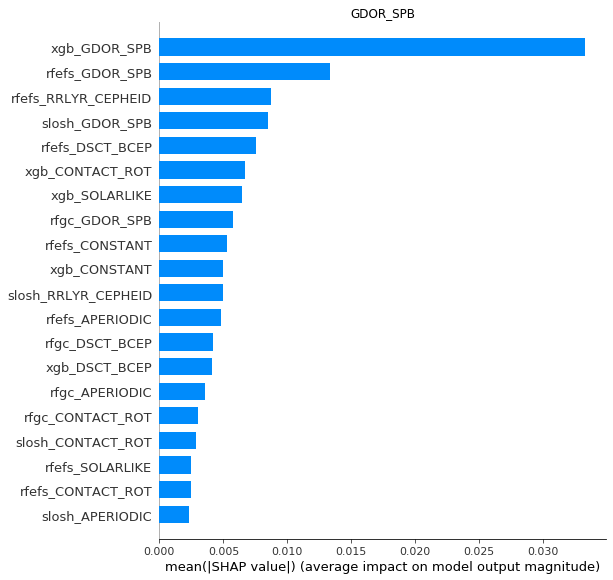

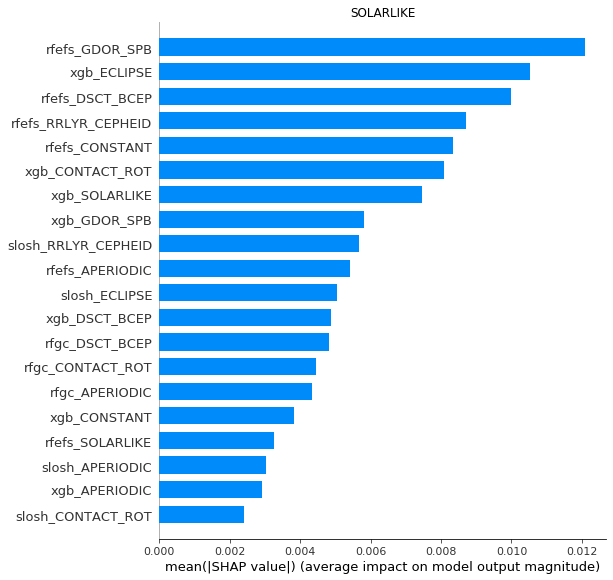

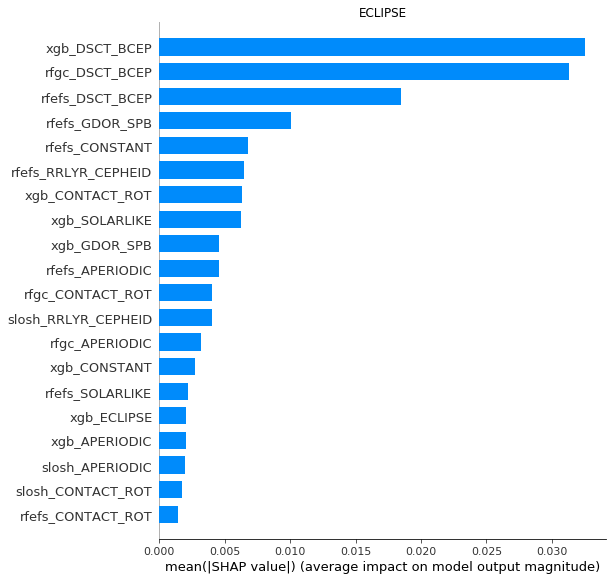

In [114]:
for i in range(len(class_names)):
    plt.figure(i)
    plt.title(class_names[i])
    shap.summary_plot(shap_values[i], X_test, 
                      feature_names=feature_names,
                      class_names=class_names[i], plot_type="bar")
    plt.savefig(class_names[i]+'.png', bbox_inches='tight')
    plt.show()